In [2]:
!pip install torchsummary

In [3]:
# Imports

import os
import zipfile

from typing import List, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import re
import torchsummary
import torchvision.transforms
import seaborn as sns

from torch import nn, optim
from tqdm import tqdm
from torchvision.datasets.folder import default_loader, DatasetFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from joblib import dump

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Custom ImageFolder class

def valid_file(filename: str) -> bool:
    """Check if current file has valid extension"""

    return filename.lower().endswith(('.jpg', '.png'))


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.

    This function searches for subdirectories in the specified directory and returns a list of class names and
    dictionary mapping each class name to its corresponding index.

    The function only includes subdirectories whose names match the regular expression 'apple'. This is intended to
    filter the classes for a specific type of dataset.

    :param directory: The root directory of the training dataset.

    :returns: A tuple containing a list of strings where each string is the name of a class folder and dictionary
    that maps each class name to its corresponding index.

    :raises FileNotFoundError: If no class folders are found in the specified directory.
    """

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()
                     and re.search('apple', entry.name))
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


class CustomImageFolder(torchvision.datasets.DatasetFolder):
    """ Implements custom ImageFolder class that overrides DatasetFolder methods, so it's possible to load only
    specific subdirectories(classes) of the directory instead of the whole directory.

    Enables two valid extensions (.jpg, .png)
    """

    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_valid_file=valid_file):
        super().__init__(root, transform=transform, target_transform=target_transform, loader=loader, is_valid_file=is_valid_file)
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        return find_classes(directory)

In [5]:
# Visualization

def show_dataset(dataset: DatasetFolder | Subset, n=6) -> None:
    """Shows grid of images as a single image

    :param dataset: Loaded torchvision dataset
    :param n: Number of rows and columns
    """

    # Transform image from tensor to PILImage
    transform = torchvision.transforms.ToPILImage()
    img = np.vstack([np.hstack([np.asarray(transform(dataset[i][0])) for _ in range(n)])
                     for i in range(n)])
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def show_batch(dataset_loader: DataLoader , num_of_images: int = 9) -> None:
    """Displays images before feeding them to the model

    :raises AssertionError: If number of images to display exceeds batch size
    """

    batch_size = dataset_loader.batch_size

    try:
        assert num_of_images < batch_size,\
            f"Number of images to display exceeds batch size: {num_of_images} > {batch_size}"

        data_iter = iter(dataset_loader)
        images, labels = next(data_iter)

        plt.figure(figsize=(10, 10))
        transform = torchvision.transforms.ToPILImage()
        for i in range(num_of_images):
            ax = plt.subplot(3, 3, i + 1)
            img = np.asarray(transform(images[i]))
            plt.imshow(img)
            plt.axis('off')

        plt.show()

    except AssertionError as msg:
        print("Error:", msg)


def plot_confusion_matrix(y_test, y_pred, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, xticks_rotation="vertical",
                                        ax=ax, colorbar=False)
    plt.show(block=False)

In [6]:
# Utils

def loader_shape(dataset_loader: DataLoader) -> Tuple[torch.Size, torch.Size]:
    """Prints shape of loaded dataset

    :returns: Tuple of tensor shapes (images, labels)
    """

    data_iter = iter(dataset_loader)
    images, labels = next(data_iter)

    return images.shape, labels.shape


def get_device() -> torch.device:
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")

    return device


def stratify_split(dataset: CustomImageFolder) -> Tuple[Subset, Subset, Subset]:
    train_size = int(len(dataset) * 0.8)
    val_size = int(len(dataset) * 0.1)
    test_size = len(dataset) - train_size - val_size

    # Split the dataset -> using sklearn split method with stratify
    targets = np.array(dataset.targets)
    train_idx, temp_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=val_size + test_size,
        shuffle=True,
        stratify=targets,
        random_state=seed
    )

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=test_size,
        shuffle=True,
        stratify=targets[temp_idx],
        random_state=seed
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)

    return train_dataset, val_dataset, test_dataset


def print_class_distribution(dataset: DatasetFolder, train_dataset: Subset, val_dataset: Subset, test_dataset: Subset) -> None:
    # Check distribution of classes in train, val and test datasets
    train_target_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_target_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_target_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_targets = []
    for batch in train_target_loader:
        train_targets.extend(batch[1].tolist())

    val_targets = []
    for batch in val_target_loader:
        val_targets.extend(batch[1].tolist())

    test_targets = []
    for batch in test_target_loader:
        test_targets.extend(batch[1].tolist())

    train_counts = [train_targets.count(i) for i in range(len(dataset.classes))]
    val_counts = [val_targets.count(i) for i in range(len(dataset.classes))]
    test_counts = [test_targets.count(i) for i in range(len(dataset.classes))]

    print("Train class distribution:", train_counts)
    print("Val class distribution:", val_counts)
    print("Test class distribution:", test_counts)

In [7]:
# Model

import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    """Convolutional block with two 3x3 convolutional layers followed by batch normalization layers and max pooling."""

    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)

        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        """Applies the convolutional block to the input tensor x."""

        return self.conv_block(x)


class ResidualBlock(nn.Module):
   """Residual block with two convolutions followed by batch normalization layers"""

   def __init__(self, in_channels: int, hidden_channels: int,  out_channels: int):
       super().__init__()
       self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
       self.bn1 = nn.BatchNorm2d(hidden_channels)

       self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
       self.bn2 = nn.BatchNorm2d(out_channels)

   def residual_block(self, x):
       x1 = F.relu(self.bn1(self.conv1(x)))
       x2 = F.relu(self.bn2(self.conv2(x1)))
       return x2 + x

   def forward(self, x): return self.residual_block(x)


class LinearBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, after_conv: bool = False):
        super().__init__()

        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_channels * 14 * 14, out_channels) if after_conv else nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)

    def linear_block(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        return x

    def forward(self, x): return self.linear_block(x)


class ResModel(nn.Module):

    def __init__(self):
        super(ResModel, self).__init__()

        self.conv1 = ConvBlock(3, 32, 32)
        self.res1 = ResidualBlock(32, 32, 32)

        self.conv2 = ConvBlock(32, 64, 64)
        self.res2 = ResidualBlock(64, 64, 64)

        self.conv3 = ConvBlock(64, 128, 128)
        self.res3 = ResidualBlock(128, 128, 128)

        self.conv4 = ConvBlock(128, 256, 256)
        self.res4 = ResidualBlock(256, 256, 256)

        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = LinearBlock(256, 512, after_conv=True)
        self.fc2 = LinearBlock(512, 512)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512, 4)
        )

    def forward(self, x):
        # Conv blocks
        x = self.conv1(x)
        x = self.res1(x)

        x = self.conv2(x)
        x = self.res2(x)

        x = self.conv3(x)
        x = self.res3(x)

        x = self.conv4(x)
        x = self.res4(x)

        # Linear blocks
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = self.fc2(x)

        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
# Config

root_dir = '/kaggle/input/crop-diseases/data/plant_dataset_original/plant_diseases_images'
model_storage_dir = '/kaggle/output/models_storage'

batch_size = 32
epochs = 6
seed = 255

adamax_lr = 0.001
adamax_weight_decay = 0.001

torch.manual_seed(seed)

In [13]:
if not os.path.exists(model_storage_dir + '/saved_models'):
    os.makedirs(model_storage_dir + '/saved_models')
    
if not os.path.exists(model_storage_dir + '/best_model_state'):
    os.makedirs(model_storage_dir + '/best_model_state')
    
if not os.path.exists(model_storage_dir + '/curr_model_state'):
    os.makedirs(model_storage_dir + '/curr_model_state')
    
if not os.path.exists(model_storage_dir + '/export_models'):
    os.makedirs(model_storage_dir + '/export_models')

cuda


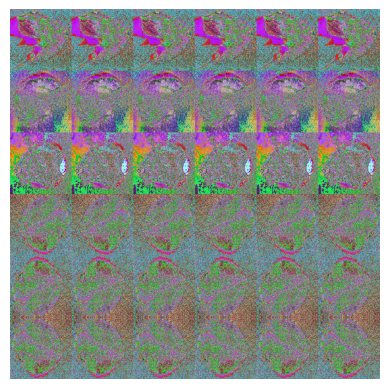

Number of training samples: 14878
Number of validation samples: 1859
Number of test samples: 1861


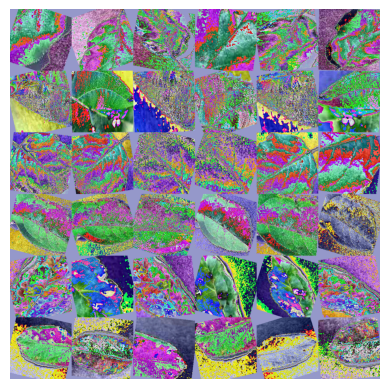

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


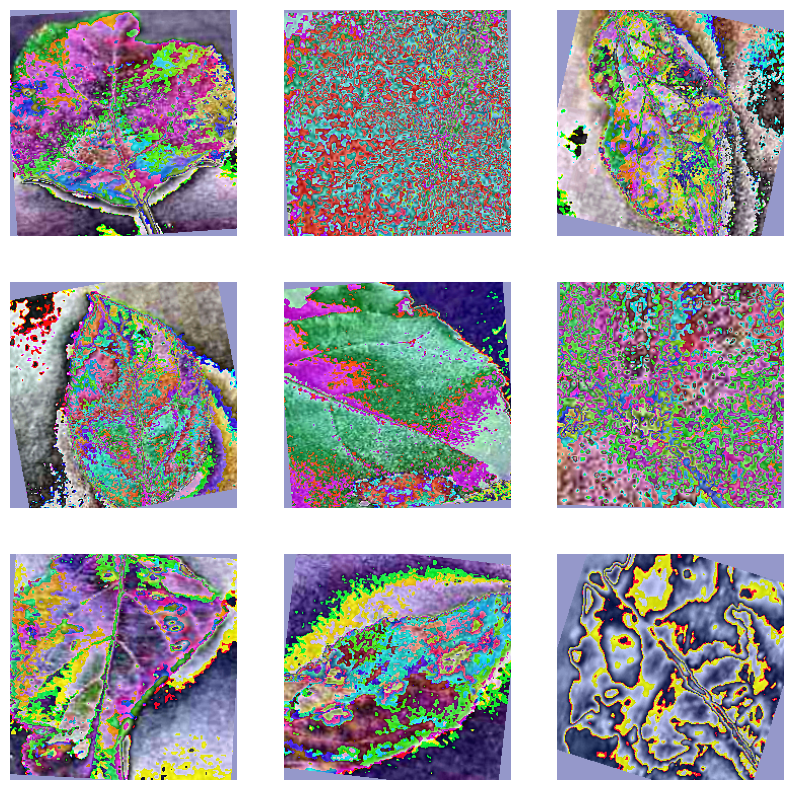

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             896
       BatchNorm2d-2         [32, 32, 224, 224]              64
            Conv2d-3         [32, 32, 224, 224]           9,248
       BatchNorm2d-4         [32, 32, 224, 224]              64
         MaxPool2d-5         [32, 32, 112, 112]               0
         ConvBlock-6         [32, 32, 112, 112]               0
            Conv2d-7         [32, 32, 112, 112]           9,248
       BatchNorm2d-8         [32, 32, 112, 112]              64
            Conv2d-9         [32, 32, 112, 112]           9,248
      BatchNorm2d-10         [32, 32, 112, 112]              64
    ResidualBlock-11         [32, 32, 112, 112]               0
           Conv2d-12         [32, 64, 112, 112]          18,496
      BatchNorm2d-13         [32, 64, 112, 112]             128
           Conv2d-14         [32, 64, 1

In [14]:
# Preprocessing
device = get_device()
print(device)

writer = SummaryWriter(model_storage_dir + '/runs/model_01')

dataset_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.44050441, 0.47175582, 0.4283929), (0.16995976, 0.14400921, 0.19573698))
])



dump(dataset_transforms, model_storage_dir + '/saved_models/transform.joblib', compress=True)

dataset = CustomImageFolder(root=root_dir, loader=default_loader, transform=dataset_transforms)
show_dataset(dataset)

train_dataset, val_dataset, test_dataset = stratify_split(dataset)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.ColorJitter(brightness=.05, contrast=0.5, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(20, interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                          expand=False),
    torchvision.transforms.RandomGrayscale(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset.dataset.transform = train_transforms
show_dataset(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           num_workers=2, pin_memory=True,
                                           generator=torch.Generator().manual_seed(seed))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                         num_workers=2, pin_memory=True,
                                         generator=torch.Generator().manual_seed(seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          num_workers=2, pin_memory=True,
                                          generator=torch.Generator().manual_seed(seed))

images_shape, labels_shape = loader_shape(train_loader)
print(f'Images shape: {images_shape}\nLabels shape: {labels_shape}')

show_batch(train_loader)

model = ResModel().to(device)
torchsummary.summary(model, (3, 224, 224), batch_size=batch_size)

loss_fn = nn.NLLLoss().to(device)
# loss_fn = nn.CrossEntropyLoss().to(device)

# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters()) # default lr=0.01
optimizer = optim.Adamax(model.parameters(), lr=adamax_lr, weight_decay=adamax_weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=2)

In [ ]:
# Train

best_val_acc = 0.0
loss = None

train_per_epoch = int(len(train_dataset) / batch_size)
for e in range(epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    model.train()

    train_acc = 0
    train_losses = []
    for idx, (images, labels) in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        output = model(images)
        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        writer.add_scalar('loss', loss.item(), (e * train_per_epoch) + idx)

        predictions = output.argmax(dim=1, keepdims=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / len(predictions)

        loop.set_description(f"Epoch [{e}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)
        writer.add_scalar('acc', accuracy, (e * train_per_epoch) + idx)

        train_acc += correct
        train_losses.append(loss.item())
    else:
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, model_storage_dir + '/curr_model_state/last_train_model_state.pth')

    train_acc /= len(train_dataset)
    train_loss = np.array(train_losses).mean()
    print(f'Epoch [{e}/{epochs}]: Train accuracy = {train_acc:.4f} Validation loss: {train_loss:.4f}')

    scheduler.step()
    # print(scheduler.get_last_lr()[0])

    val_acc = 0.0
    val_losses = []
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            val_loss = loss_fn(scores, y)
            val_losses.append(val_loss.item())

            _, predictions = scores.max(1)
            val_acc += (predictions == y).sum().item()

    val_acc /= len(val_dataset)
    val_loss = np.array(val_losses).mean()
    print(f'Epoch [{e}/{epochs}]: Validation accuracy = {val_acc:.4f} Validation loss: {val_loss:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }, model_storage_dir + '/curr_model_state/last_best_val_epoch_model_state.pth')

In [ ]:
# Test

num_correct = 0
num_samples = 0
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader: # images, labels
        x = x.to(device=device)
        y = y.to(device=device)

        scores = model(x)
        _, predictions = scores.max(1)

        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    print(f'Model correctly predicted {num_correct} of total {num_samples} images with accuracy of'
          f' {float(num_correct) / float(num_samples) * 100:.2f}%')

In [ ]:
# Analysis

plot_confusion_matrix(y_true, y_pred, dataset.classes)

report = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
df = pd.DataFrame(report).transpose()
df = df.drop(['support'], axis=1)
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

torch.save(model.state_dict(), model_storage_dir + '/saved_models/ResModel.pth')